In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 34.69 MiB/s, done.


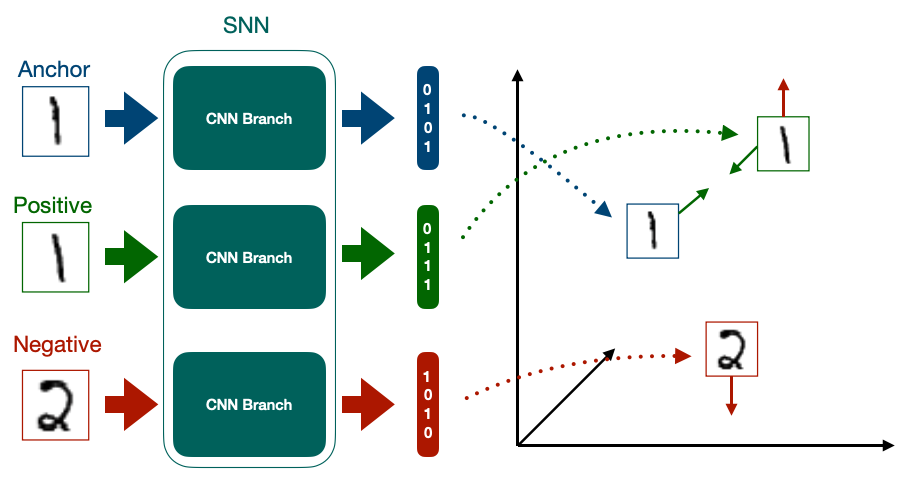

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE=32
LR=0.001
EPOCHS=15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

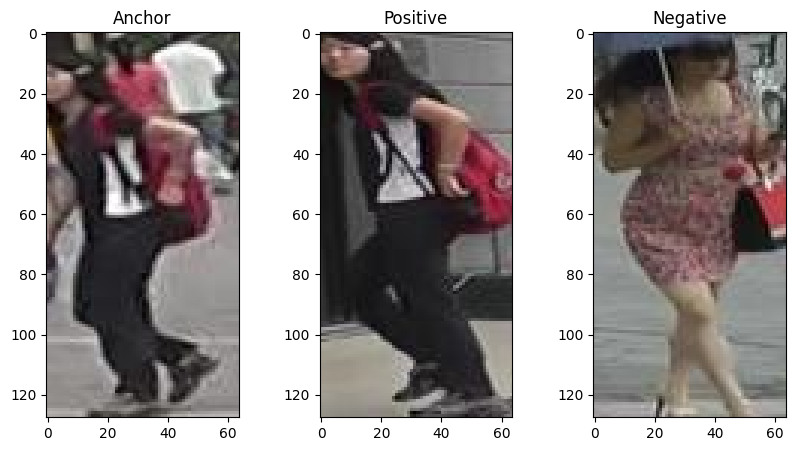

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self,df):
    self.df=df

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row= self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


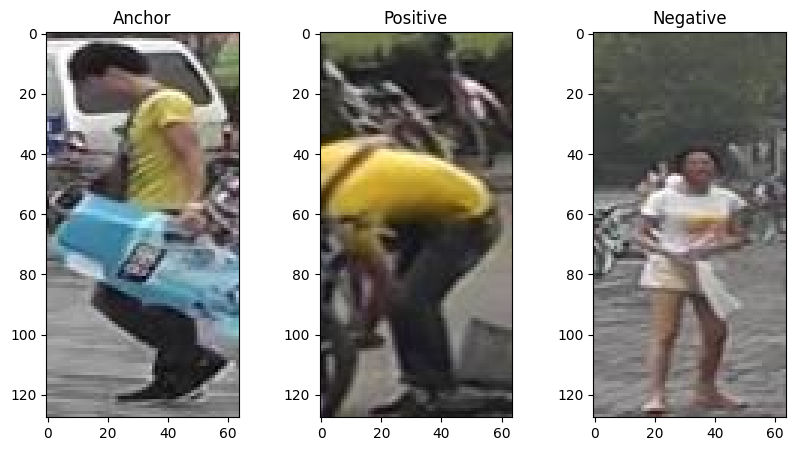

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader= DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features= self.efficientnet.classifier.in_features, out_features= emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)

    return embeddings


In [ ]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  total_loss=0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs=model(A)
    P_embs=model(P)
    N_embs=model(N)

    loss= criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader,  criterion):

  model.train()
  total_loss=0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs=model(A)
      P_embs=model(P)
      N_embs=model(N)

      loss= criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

      return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [ ]:
best_valid_loss= np.Inf

for i in range(EPOCHS):

  train_loss=train_fn(model,trainloader,optimizer,criterion)
  valid_loss=eval_fn(model,validloader,criterion)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss=valid_loss
    print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.009082607626914978 valid_loss : 0.0378580904006958


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 2 train_loss : 0.008076893091201782 valid_loss : 0.0382705020904541


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 0.01098126769065857 valid_loss : 0.03723229169845581


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 0.009117249846458435 valid_loss : 0.03514508724212646


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 5 train_loss : 0.010394840240478516 valid_loss : 0.034026005268096925


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 6 train_loss : 0.008718355298042298 valid_loss : 0.03338973045349121


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 train_loss : 0.008188371658325195 valid_loss : 0.03287059783935547


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 8 train_loss : 0.009338129162788391 valid_loss : 0.032621185779571536


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 9 train_loss : 0.013201282024383545 valid_loss : 0.03264396190643311


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 10 train_loss : 0.006452579498291016 valid_loss : 0.03336027622222901


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 11 train_loss : 0.008645950555801392 valid_loss : 0.031862566471099855


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 12 train_loss : 0.007571616172790527 valid_loss : 0.031200103759765625


  0%|          | 0/25 [00:00<?, ?it/s]


EPOCHS : 13 train_loss : 0.007235144376754761 valid_loss : 0.031288342475891115


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 14 train_loss : 0.007592552900314331 valid_loss : 0.030389928817749025


  0%|          | 0/25 [00:00<?, ?it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 15 train_loss : 0.007562180161476135 valid_loss : 0.02834336757659912


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_imag_names): # this function takes anc_imag_names as argument
    anc_img_names_arr = np.array(anc_imag_names) # Fix: using anc_imag_names here, argument passed to function
    encodings=[]

    model.eval()
    with torch.no_grad():
     for i in tqdm(anc_img_names_arr):
        A= io.imread(DATA_DIR + i)
        A= torch.from_numpy(A).permute(2,0,1) / 255.0
        A= A.to(DEVICE)
        A_enc= model(A)
        A_enc= model(A.unsqueeze(0))
        encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)

        return df_enc

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

<ipython-input-46-fb78bba7c639>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
  0%|          | 0/4000 [00:00<?, ?it/s]


AssertionError: expected 4D input (got 3D input)

In [ ]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist= np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [ ]:
idx=0
img_name =df_enc['Anchor'].iloc[idx]
img_path= DATA_DIR +img_name

img= io.imread(img_path)
img= torch.from_numpy(img).permute(2,0,1) / 255.0

model.eval()
with torch.no_grad():
  img= img.to(DEVICE)
  img_enc= model(img.unsqueeze(0))
  img_enc= img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names= df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance,dist)

In [ ]:
closest_idx = np.argsort(distance)

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);